In [1]:
import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import linregress
import matplotlib.pyplot as plt
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
from scipy.signal import argrelextrema

from libs.helper_05_tutorial import *


# Many two level systems

## Recap

Last time we saw that when we add just one extra TLS we got surprising new physics - non radiative excitation transfer. What happens when we continue adding TLS? That's what this tutorial is going to be about.

Last time, we motivated that for many TLS, a helpful way to write the Hamiltonian as

$$H =  \Delta E J_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_x$$

In [2]:
H_latex = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_x = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_y = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_z = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$



## Computational bottleneck

We can generalise our "make_operators" function from last time to create operators for an arbitrary number of TLS

In [3]:
def make_operators(max_bosons, parity=0, num_TLS=1):
    
    a     = tensor([destroy(max_bosons+1)] + [qeye(2) for i in range(1,num_TLS+1)])      # tensorised boson destruction operator
    J     = jspin(num_TLS, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])                # tensorised J^2 operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n, *ms) for n in possible_ns for ms in product(possible_ms, repeat=num_TLS)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        J2              = J2.extract_states(p)  
        nm_list        = [nm_list[i] for i in p]
  
    
    return two_state, bosons, interaction, number, nm_list, J2

Right now, the use of J's is allowing us to look at the values of `pseudo-angular momentum` in our system (through the operator J2). We are not however taking advantage of the conservation ideas we spoke about last time and we need to do this to avoid running out of computational resources.

It might seem premature to worry about computational resources, but take a look at what happens when we want to create operators to run simulations on just 32 TLS with only max_bosons=2


In [421]:
two_state, bosons, interaction, number, nmm_list, J2 = make_operators(max_bosons=18, parity=0, num_TLS=18)


We run out of memory and this is because the number of states needed to describe our system grows exponentially with the number of TLS - every TLS doubles the number of states.

So, how does conservation of `pseudo-angular momentum` help us? Let's explore.

## Pseudo-angular momentum $J$

### Angular momentum operators

Although we don't explicitly have a description of angular momentum in our TLS, you may recall from tutorial 2 that our system is mathematically similar to spin 1/2 particles which do have angular momentum.

So far, we've seen that the x and z "components" of the total angular momentum operator $J_x$ and $J_z$ are used in the Hamiltonian. I use quote marks around "component" because this is vector language which is not obviously applicable to operators. It turns out, however, that we can (in some sense) treat the angular momentum operator as a vector (see [spinors](https://en.wikipedia.org/wiki/Spinors_in_three_dimensions)). We can create the squared "magnitude" of the total angular momentum operator ($J^2$) much like we would a vector - we sum of the squares of the components.

Let's see this for the case of 2 TLS.

In [362]:
Jx, Jy, Jz = jspin(2, basis="uncoupled")
J2 = Jx*Jx + Jy*Jy + Jz*Jz
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

What does this operator tell us?

Just as we learnt about energy by calculating the eigenvalues and eigenvectors of the Hamiltonian, we can learn about states of constant angular momentum by calculating the eigenvalues and eigenvectors of $J^2$.

In [59]:
evalsJ, eketsJ = J2.eigenstates()

In [60]:
evalsJ

array([0., 2., 2., 2.])

Although not immediately obvious, the eigenvalues of $J^2$ [always have the form $j(j+1)$](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7), where $j$ is a number that characterises the angular momentum of the system with $2j$ being an integer. Therefore, even without explicitly looking at the eigenstates of $J^2$, we know there must be:
- 1 state with $j=0$
- 3 states with $j=1$

But, where do these $j$ numbers come from, and what does it mean to have many states with the same value of $j$?


In quantum mechanics, it has been found experimentally that [angular momentum is quantised](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7) in the sense that when its z component is measured it can only take values $m\hbar$ where $m = j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$.

So although we still haven't explicitly looked the 4 eigenstates of $J^2$, we can say that they can be described by 2 numbers $|j, m \rangle$, namely:

- $|0, 0 \rangle$
- $|1, -1 \rangle$
- $|1, 0 \rangle$
- $|1, 1 \rangle$

The specific $j$ and $m$ numbers come from adding up the angular momentum for many single TLS (with $j=1/2$) like vectors of the same length but different (quantised) orientations. The details are somewhat tedious - often involving [formidable lookup tables](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-clebsch-gordan-coefs.pdf). Luckily for us, QuTiP, has some convenient functions (that are somewhat hidden inside of [`qutip.cy.piqs`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx)) to help us.
- [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) - tells us the different $j$ values for $N$ TLS.
- [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) tells us the $m$ values for a given $j$


It's worth noting that in moving from a $|\pm, \pm, \pm, ...\rangle$ description of the system to $| j,m\rangle$:
1. we lose the ability to distinguish which specific TLS is excited
2. we lose the ability to describe every state uniquely, in other words there can be many states with the same $j,m$ values (degenerate states)

Are these trade offs ok to make?

On point 1, for systems of indistinguishable particles this is the best way to describe the system

On point 2, in general there are some subtleties to consider when ignoring degeneracy which might need to be considered depending on the problem at hand (see last paragraph of [Permutational Invariant Quantum Solver](http://qutip.org/docs/latest/guide/dynamics/dynamics-piqs.html)). For now, we don't need to worry about this so we will put a pin in this advanced topic and return to it in a later tutorial.

> Advanced: Use [`state_degeneracy(N,j)`](https://qutip.org/docs/4.4/apidoc/functions.html?highlight=m_degeneracy#qutip.piqs.state_degeneracy) in combination with [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) & [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) to enumerate all the $2^N$ states

### Angular momentum conservation

Our knowledge of the conservation of physical angular momentum motivates us to explore pseudo angular momentum conservation. We always want to find quantities that are conserved because it normally helps you simplify the system dynamics.

Just like parity, we can explore the conservation of pseudo-angular momentum by looking at the commutator of $J^2$ with the $H$.

In [73]:
two_state, bosons, interaction, number, nmm_list, J2 = make_operators(max_bosons=2, parity=0, num_TLS=2)

In [74]:
U=0.01
omega=1
deltaE=1

In [75]:
H = deltaE*two_state + omega*bosons + U*interaction

In [76]:
np.all(commutator(H,J2).full() == 0)

True

The zero commutator tells us that pseudo-angular momentum is conserved. This means that states of constant energy are also states of constant angular momentum. It also means that if we set up our system with a specific $j$ then we don't have to worry about all the others. 

In addition, the largest number of states that we then need to consider comes when we have maximum $j$, i.e. $j_{\text{max}} = \frac{1}{2} N$. In this case, the number of possible $m$ values is $2j+1 = N+1$ - this grows linear with $N$ rather than exponentially so is much more favourable for doing simulations for large $N$.

How can we isolate a single $j$ for our simulations? Luckily for us QuTiP has a function [`jmat`](https://qutip.org/docs/4.4/apidoc/functions.html#qutip.operators.jmat) that allows us to create the angular momentum operators for a specific $j$. 

For example, let's look at the $j=1$ case for 2 TLS.

In [355]:
Jx, Jy, Jz = jmat(1)
Jz

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]

This reduced $J_z$ operator corresponding to $j=1$ produces $m=-1,0,+1$ if we operate on $|j, m \rangle$ states represented as: 

$$
|1,1> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|1,0> = \begin{bmatrix}
 0   \\
 1   \\
0   \\
\end{bmatrix}, 
|1,-1> = \begin{bmatrix}
 0   \\
 0   \\
1   \\
\end{bmatrix}
$$

For a general $j$ we would have 

$$
|j,j> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|j,j-1> = \begin{bmatrix}
 0   \\
 1   \\
0   \\
\end{bmatrix}, ... 
|j,-j> = \begin{bmatrix}
 0   \\
 0   \\
1   \\
\end{bmatrix}
$$

With this in mind we can re-write our operator functions:
- to use `jmat` - we'll use $j_{\text{max}} = \frac{1}{2} N$
- for nm_list we'll enumerate the states in terms of number of TLS in the excited state i.e. $m+\frac{1}{2} N$

In [4]:
def make_operators_J(max_bosons, parity=0, num_TLS=1):
    
    J     = jmat(0.5) if num_TLS==1 else jmat(num_TLS//2)
    Jx    = tensor(qeye(max_bosons+1), J[0])                                             # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                             # tensorised Jx operator
    a     = tensor(destroy(max_bosons+1), qeye(J[0].dims[0][0]))                        # tensorised boson destruction operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = range(num_TLS, -1,-1)
    nm_list = [(n,m1) for (n,m1) in product(possible_ns, possible_ms)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state       = two_state.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction     = interaction.extract_states(p)
        nm_list        = [nm_list[i] for i in p]
  
    return two_state, bosons, interaction, number, nm_list

## TODO:
- Check parity

## Superradiance

### 1 TLS excited

time to emit one = 103.97599399849963


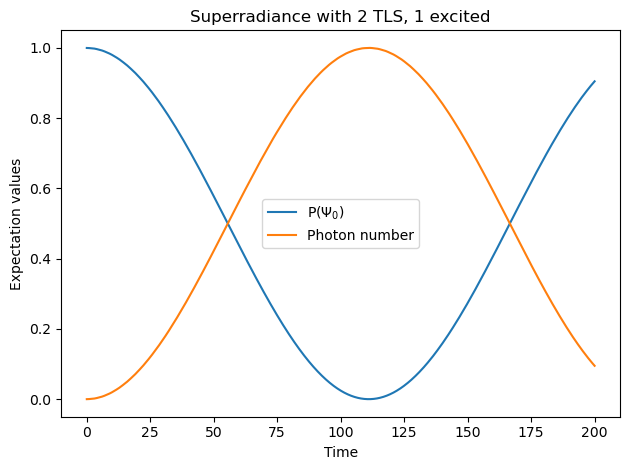

time to emit one = 73.51837959489873


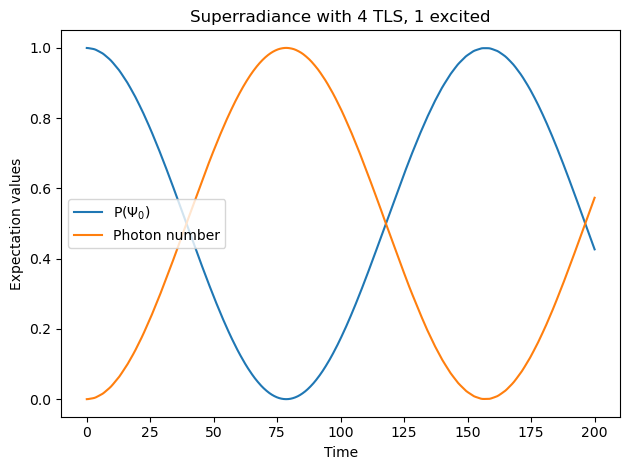

time to emit one = 51.96299074768692


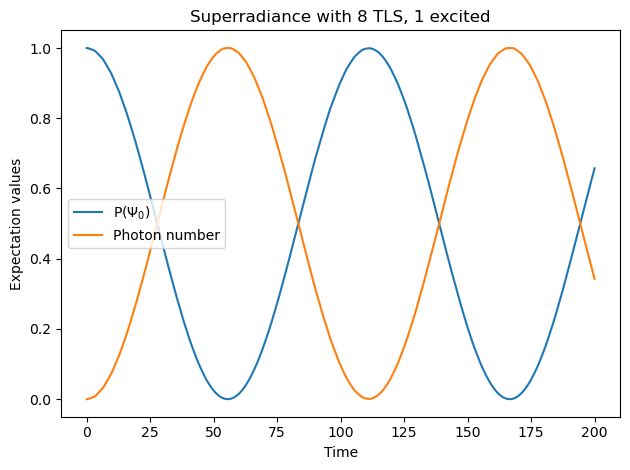

time to emit one = 36.70917729432358


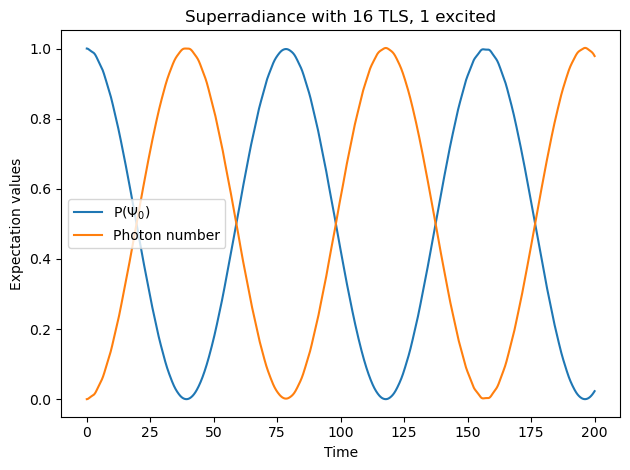

time to emit one = 25.806451612903228


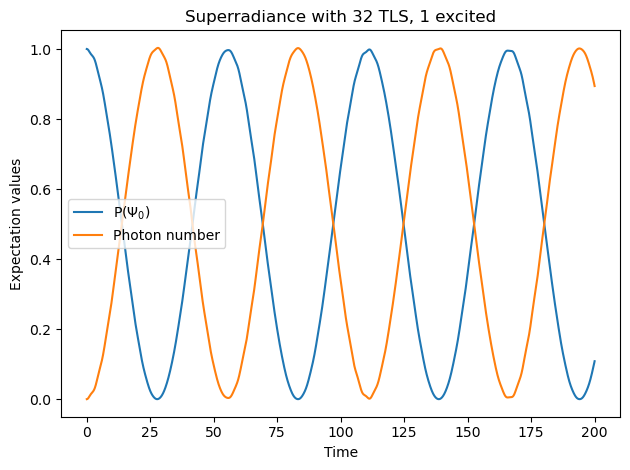

time to emit one = 23.205801450362593


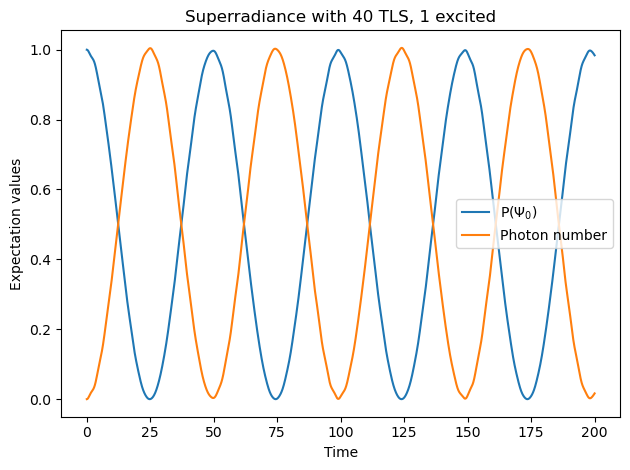

In [408]:
U=0.01
omega=1
deltaE=1

Ns = [2,4,8,16,32,40]
transfer_times = []
rates = []

for N in Ns:
    num_excited =  1
    max_bosons = num_excited*2
    
    two_state, bosons, interaction, number, nm_list = make_operators_J(max_bosons=max_bosons, parity=0, num_TLS=N)

    psi_atom = basis(len(m_vals(N/2)), N-1)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom)
    
    H = deltaE*two_state  + bosons + U*interaction 
    
    
    # Time list
    tlist = np.linspace(0,  200, 4000)
    
    
    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    time_to_emit_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    
    transfer_times.append(time_to_emit_one)
    rates.append(2*np.pi / time_to_emit_one)

    print(f"time to emit one = {time_to_emit_one}")

    plt.figure()
    
    plt.title(f"Superradiance with {N} TLS, {num_excited} excited")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0], label="P($\Psi_0$)")
    plt.plot(tlist, result.expect[1], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


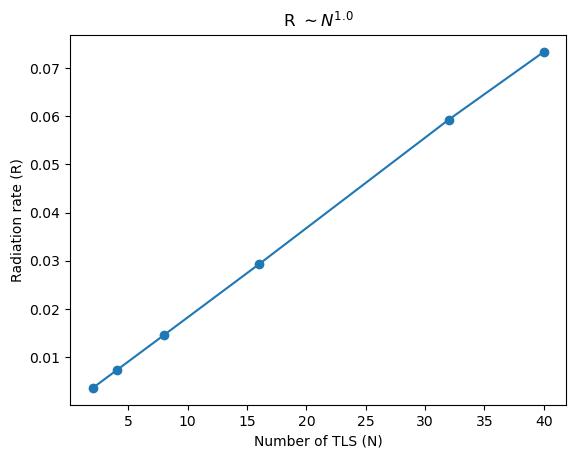

In [142]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Radiation rate (R)");

### N/2 TLS excited

time to emit one = 103.97599399849963


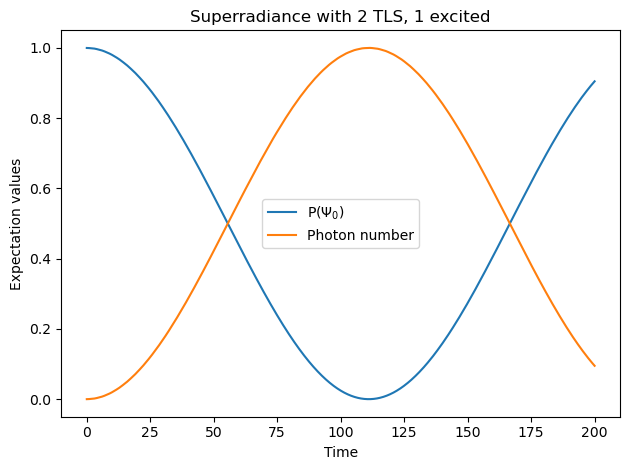

time to emit one = 43.960990247561895


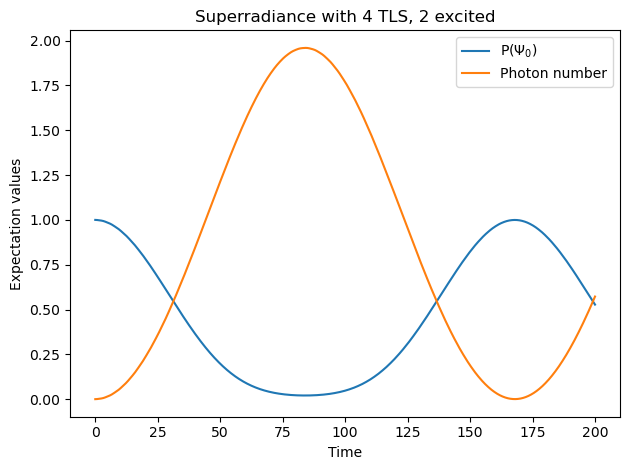

time to emit one = 22.755688922230558


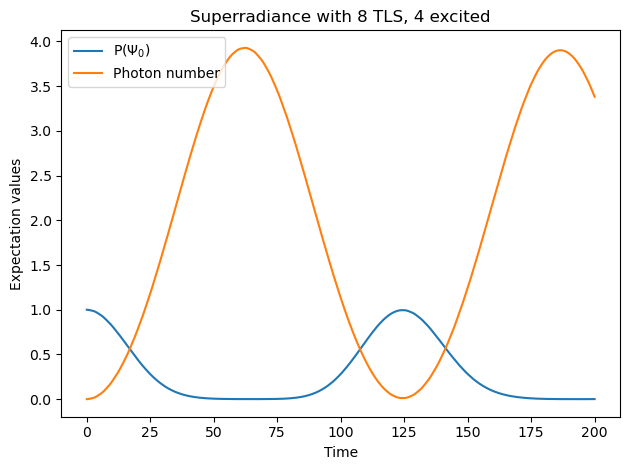

time to emit one = 11.802950737684421


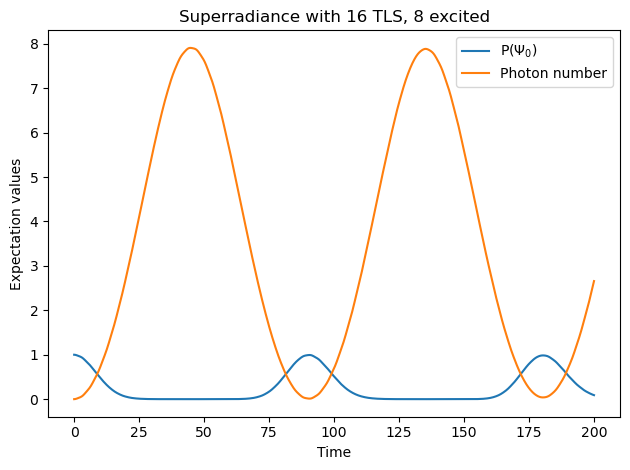

time to emit one = 6.0515128782195555


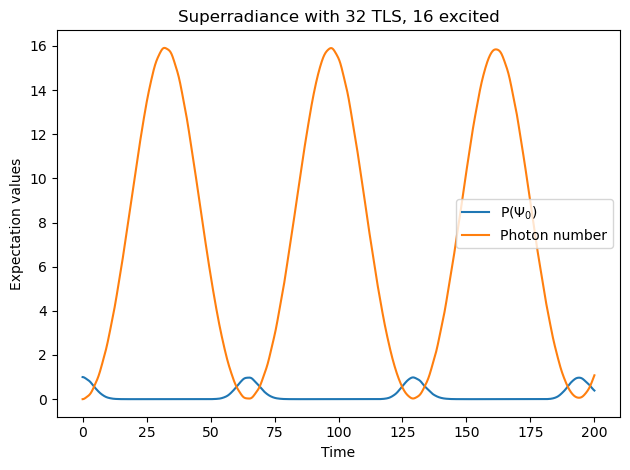

time to emit one = 4.801200300075019


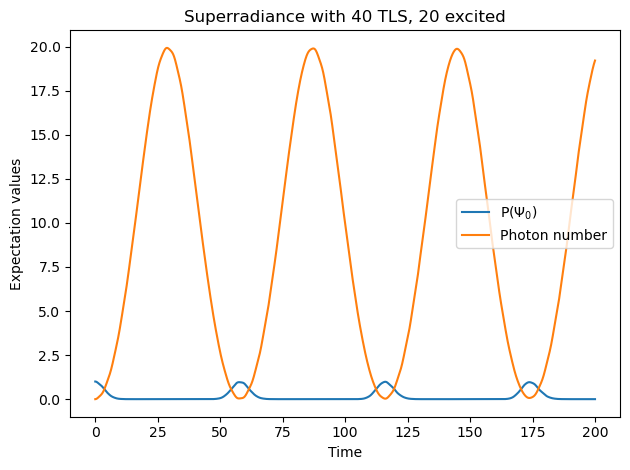

In [409]:
U=0.01
omega=1
deltaE=1
Ns = [2,4,8,16,32,40]
transfer_times = []
rates = []

for N in Ns:
    num_excited = N//2 or 1
    max_bosons = num_excited*2
    
    two_state, bosons, interaction, number, nm_list = make_operators_J(max_bosons=max_bosons, parity=0, num_TLS=N)

    psi_atom = basis(len(m_vals(N/2)), N//2)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom)
    
    H = deltaE*two_state  + bosons + U*interaction 
    
    
    # Time list
    tlist = np.linspace(0,  200, 4000)
    
    
    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    time_to_emit_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    
    transfer_times.append(time_to_emit_one)
    rates.append(2*np.pi / time_to_emit_one)

    print(f"time to emit one = {time_to_emit_one}")

    plt.figure()
    
    plt.title(f"Superradiance with {N} TLS, {num_excited} excited")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0], label="P($\Psi_0$)")
    plt.plot(tlist, result.expect[1], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


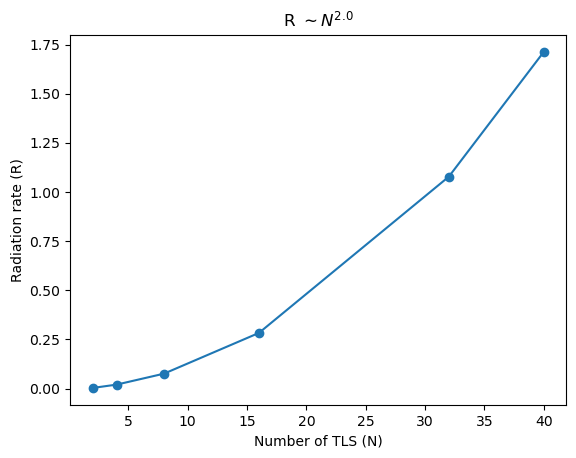

In [410]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Radiation rate (R)");


### N TLS excited

time to emit one = 73.70184254606366


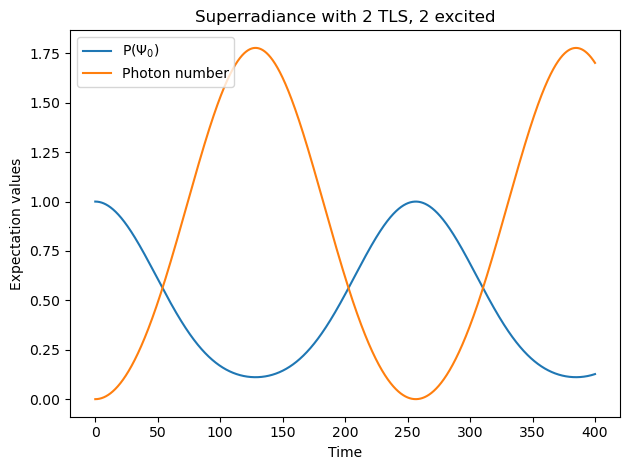

time to emit one = 47.521188029700745


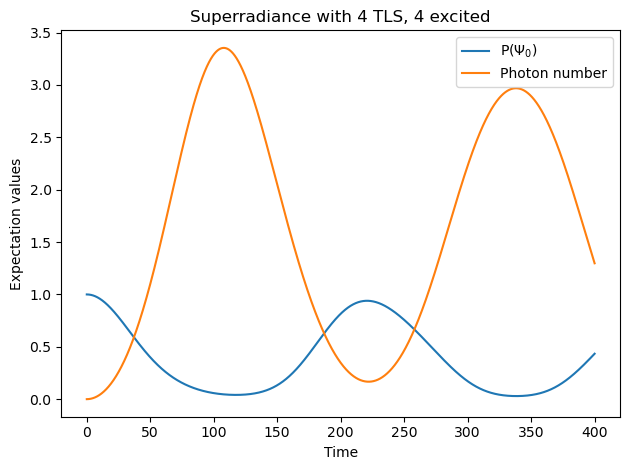

time to emit one = 32.27080677016926


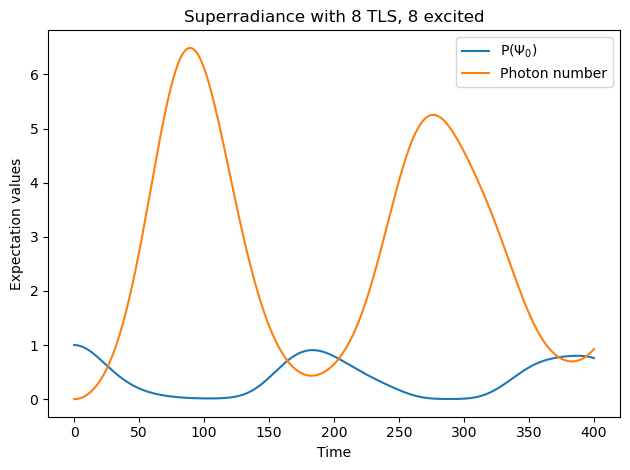

time to emit one = 22.3905597639941


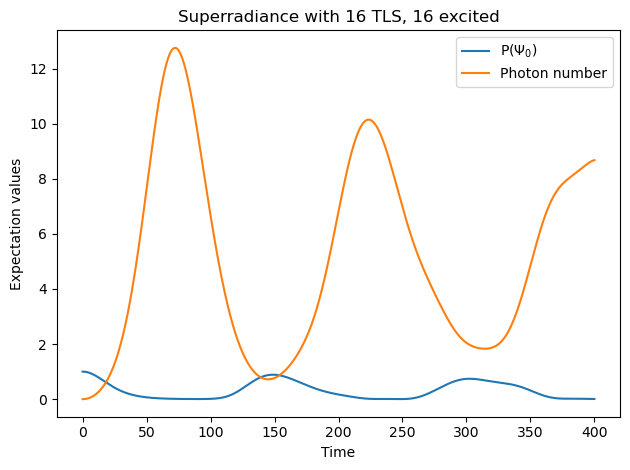

time to emit one = 15.690392259806497


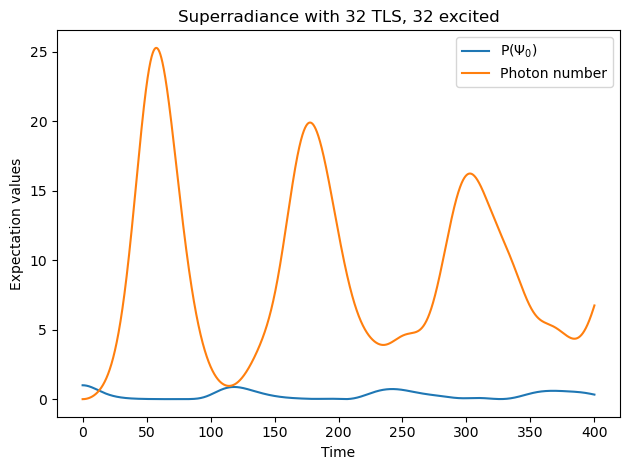

In [413]:
U=0.01
omega=1
deltaE=1
Ns = [2,4,8,16,32]
transfer_times = []
rates = []

for N in Ns:
    num_excited = N
    max_bosons = num_excited*2
    
    two_state, bosons, interaction, number, nm_list = make_operators_J(max_bosons=max_bosons, parity=0, num_TLS=N)

    psi_atom = basis(len(m_vals(N/2)), 0)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom)
    
    H = deltaE*two_state  + bosons + U*interaction 
    
    
    # Time list
    tlist = np.linspace(0,  400, 40000)
    
    
    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])
        
    # result = mesolve(H, psi0, tlist, [])


    time_to_emit_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    
    transfer_times.append(time_to_emit_one)
    rates.append(2*np.pi / time_to_emit_one)

    print(f"time to emit one = {time_to_emit_one}")

    plt.figure()
    
    plt.title(f"Superradiance with {N} TLS, {num_excited} excited")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0], label="P($\Psi_0$)")
    plt.plot(tlist, result.expect[1], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


    # probabilities=np.abs(result.states)**2
    # probabilities = probabilities.squeeze()
    
    # fig, ax = plt.subplots()
    # lines = ax.plot(tlist, probabilities)
    # ax.set_ylabel("Probability")
    # ax.set_xlabel("Time")
    # ax.legend(lines, nm_list, loc="right")
    # plt.show();

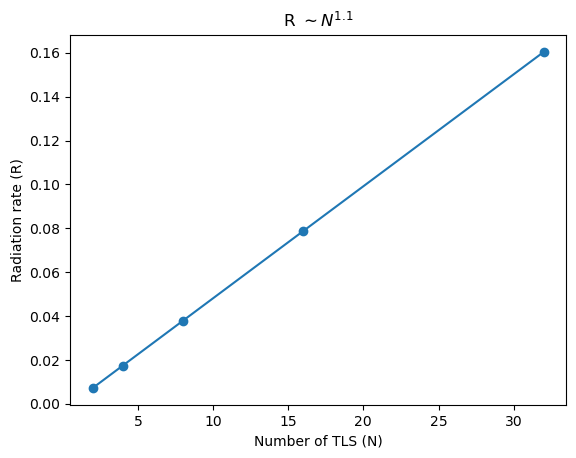

In [414]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Radiation rate (R)");


### TODO lots of chat about dicke
Also, check parity, right now we're using P=0 which makes things take longer

## Supertransfer

In [11]:
def make_operators_JAB(max_bosons, parity=0, num_TLS_A=1, num_TLS_B=1):
    
    JA     = jmat(0.5) if num_TLS_A==1 else jmat(num_TLS_A/2)
    JB     = jmat(0.5) if num_TLS_B==1 else jmat(num_TLS_B/2)
    JxA   = tensor(qeye(max_bosons+1), JA[0], qeye(JB[0].dims[0][0]))       # tensorised J𝑥 operator 
    JxB   = tensor(qeye(max_bosons+1), qeye(JA[0].dims[0][0]), JB[0])       # tensorised J𝑥 operator 
    JzA   = tensor(qeye(max_bosons+1), JA[2], qeye(JB[0].dims[0][0]))       # tensorised Jz operator 
    JzB   = tensor(qeye(max_bosons+1), qeye(JA[0].dims[0][0]), JB[2])       # tensorised Jz operator 
    a     = tensor(destroy(max_bosons+1), qeye(JA[0].dims[0][0]), qeye(JB[0].dims[0][0]))     # tensorised boson destruction operator

    two_state_A     = JzA                                 # two state system energy operator   Jz
    two_state_B     = JzB                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction_A   = 2*(a.dag() + a) * JxA               # interaction energy operator        2(𝑎†+𝑎)Jz  
    interaction_B   = 2*(a.dag() + a) * JxB               # interaction energy operator        2(𝑎†+𝑎)Jz  
    
    P = (1j*np.pi*(number + JzA + JzB + (num_TLS_A+num_TLS_B)/2)).expm()               # parity operator 
    
    # map from QuTiP number states to |n,±, ±, ...> states
    possible_ns = range(0, max_bosons+1)
    possible_ms_A = range(num_TLS_A, -1,-1)
    possible_ms_B = range(num_TLS_B, -1,-1)
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms_A, possible_ms_B)]

    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
        
        two_state_A       = two_state_A.extract_states(p)
        two_state_B       = two_state_B.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_A     = interaction_A.extract_states(p)
        interaction_B     = interaction_B.extract_states(p)
        nm_list        = [nm_list[i] for i in p]
  
    return two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list

### 1<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

time to transfer one = 41246.062303115155


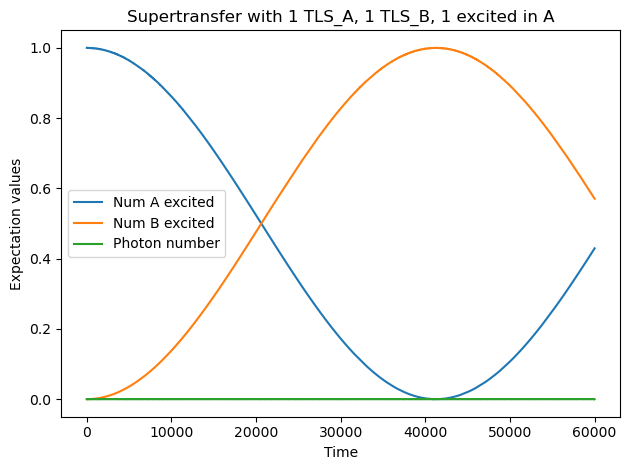

time to transfer one = 20617.03085154258


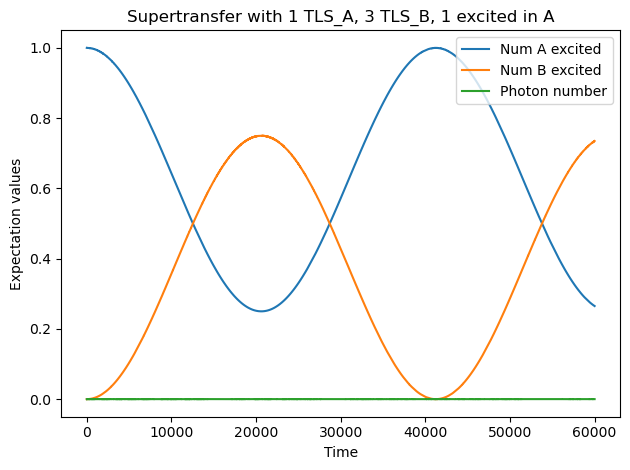

time to transfer one = 10296.514825741287


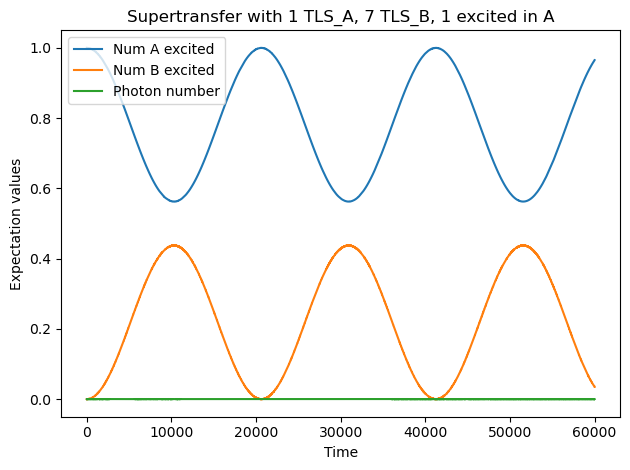

time to transfer one = 5157.257862893145


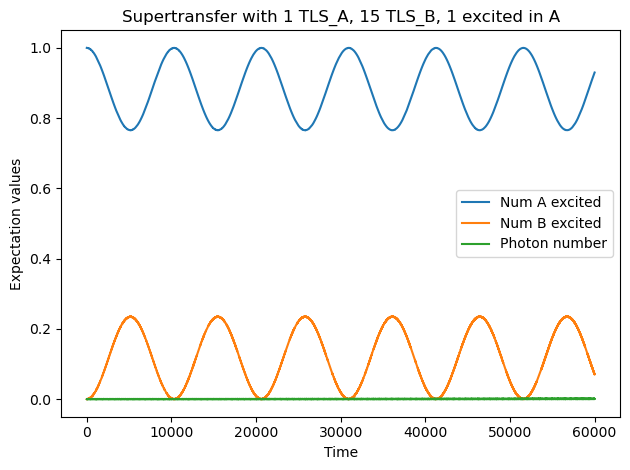

In [12]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,3,7,15]
transfer_times = []
rates = []

tend_ind = -1

for N in Ns:
    num_excited = 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list = make_operators_JAB(max_bosons=max_bosons, parity=0, num_TLS_A=1, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(1/2)), 0)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  60000, 20000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    # time_to_transfer_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    tend_ind = np.argmin((result.expect[0][0:tend_ind]))
    time_to_transfer_one = tlist[tend_ind]    

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with 1 TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + 1/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


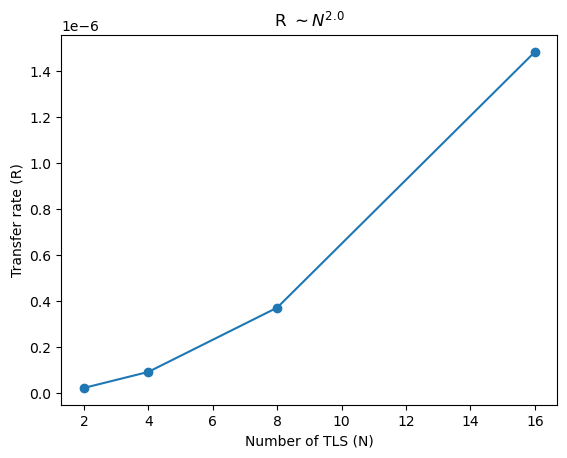

In [13]:
super = pd.DataFrame(data={"N":np.add(Ns,1), "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");

### N<sub>A</sub> : N<sub>B</sub>,  1 TLS excited in A

time to transfer one = 41246.062303115155


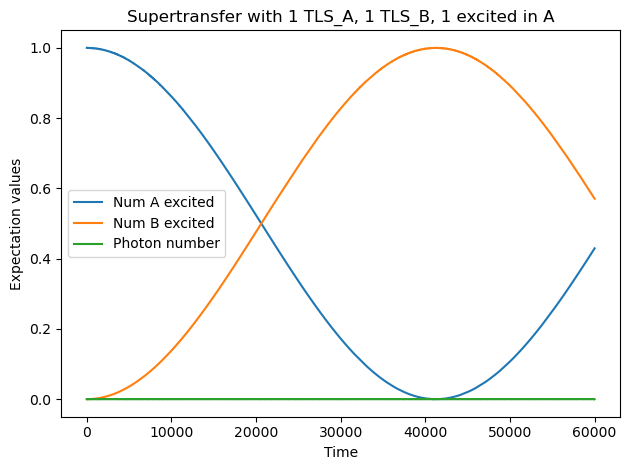

time to transfer one = 20626.03130156508


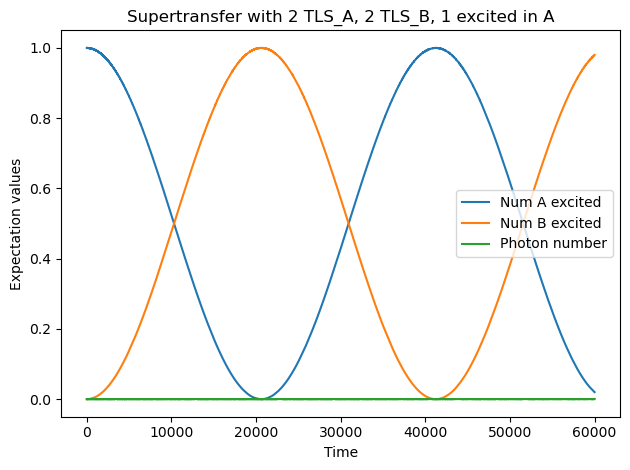

time to transfer one = 10299.514975748787


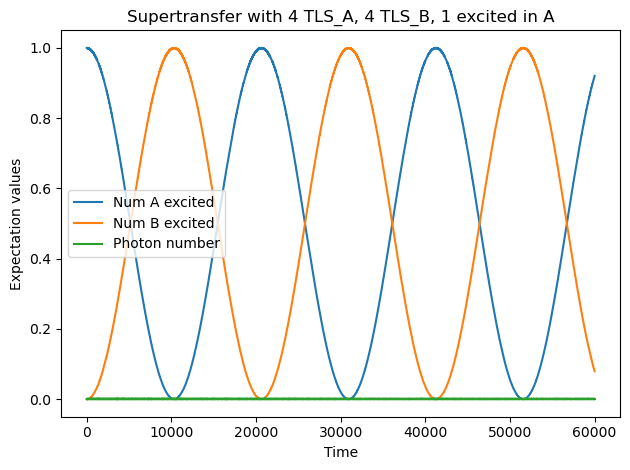

time to transfer one = 5151.257562878144


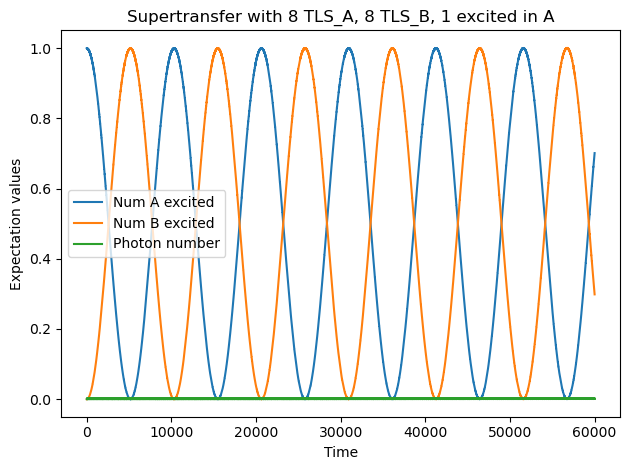

time to transfer one = 2577.1288564428223


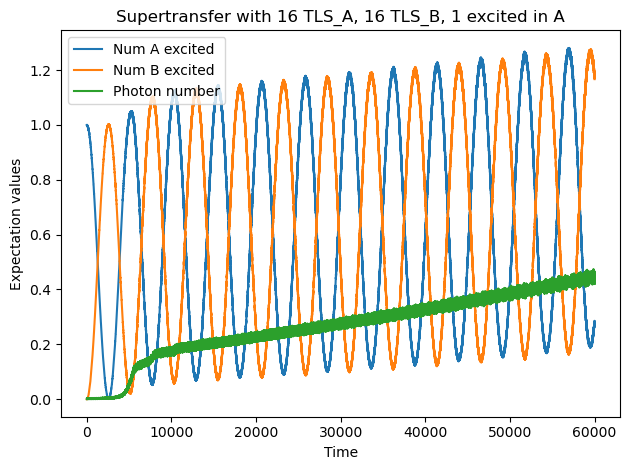

In [20]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,2,4,8,16]
transfer_times = []
rates = []

tend_ind = -1

for N in Ns:
    num_excited = 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list = make_operators_JAB(max_bosons=max_bosons, parity=0, num_TLS_A=N, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(N/2)), N-1)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  60000, 20000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    # time_to_transfer_one = tlist[np.where(np.abs((result.expect[1]-1))<0.01)[0][0]]
    tend_ind = np.argmin((result.expect[0][0:tend_ind]))
    time_to_transfer_one = tlist[tend_ind]    

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


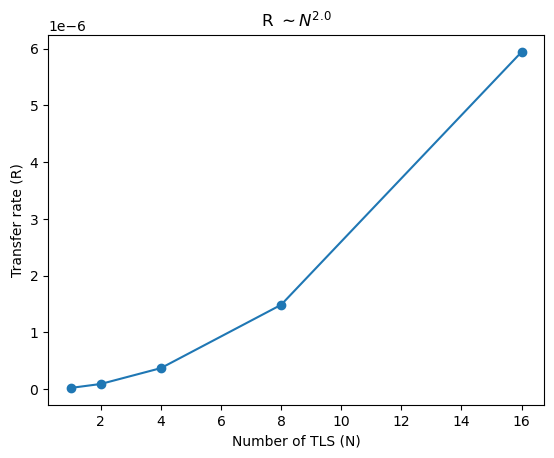

In [26]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");

### N<sub>A</sub> : N<sub>B</sub>,  N/2 TLS excited in A

In [128]:
psi0

Quantum object: dims = [[5, 5, 5], [1, 1, 1]], shape = (125, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [127]:
H

Quantum object: dims = [[5, 5, 5], [5, 5, 5]], shape = (125, 125), type = oper, isherm = True
Qobj data =
[[10.5  0.   0.  ...  0.   0.   0. ]
 [ 0.   8.   0.  ...  0.   0.   0. ]
 [ 0.   0.   5.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.  -3.   0. ]
 [ 0.   0.   0.  ...  0.   0.  -5.5]]

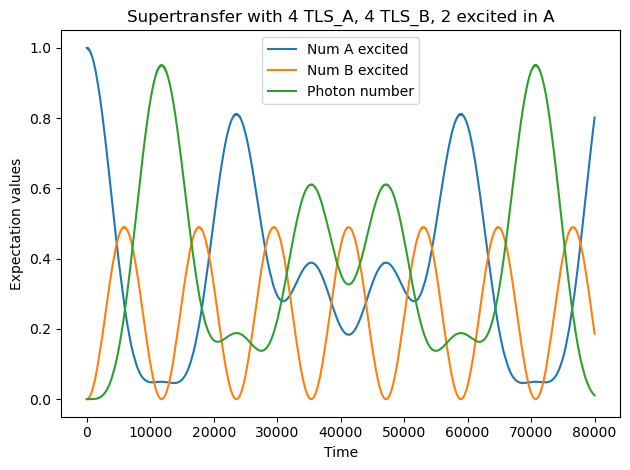

In [136]:
U=0.01
omega=1
deltaE=2.5

Ns = [4]
transfer_times = []
rates = []

tend_ind = -1
tend = 80000


for N in Ns:
    num_excited = N//2 or 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list = make_operators_JAB(max_bosons=max_bosons, parity=0, num_TLS_A=N, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(N/2)), N//2)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  tend, 10000)

    ex20 = basis([max_bosons+1, len(m_vals(N/2)), len(m_vals(N/2))], [0,N//2,N])
    ex11 = basis([max_bosons+1, len(m_vals(N/2)), len(m_vals(N/2))], [0,N//2+1,N//2+1])
    ex02 = basis([max_bosons+1, len(m_vals(N/2)), len(m_vals(N/2))], [0,N,N//2])


    # Evolve the system
    # result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    result = mesolve(H, psi0, tlist, [], [ex20*ex20.dag(), ex11*ex11.dag(), ex02*ex02.dag()])

    # tend_ind = np.where(np.abs((result.expect[1][0:-1]+ N/2 - 1))<0.01)[0][0]
    # time_to_transfer_one = tlist[tend_ind]    
    # tend = time_to_transfer_one

    
    
    # transfer_times.append(time_to_transfer_one)
    # rates.append(2*np.pi / time_to_transfer_one)

    # print(f"time to transfer one = {time_to_transfer_one}")

    # tend = time_to_transfer_one



    plt.figure()
    
    # plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    # plt.xlabel("Time")
    # plt.ylabel("Expectation values")
    # plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    # plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    # plt.plot(tlist, result.expect[2], label="Photon number")
    # plt.legend()
    
    
    # plt.tight_layout()
    # plt.show()

    plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0], label="Num A excited")
    plt.plot(tlist, result.expect[1], label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


time to transfer one = 38619.86198619862


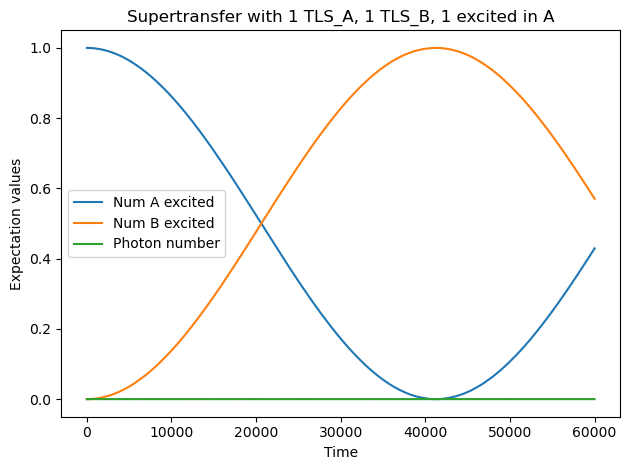

time to transfer one = 19315.724551753105


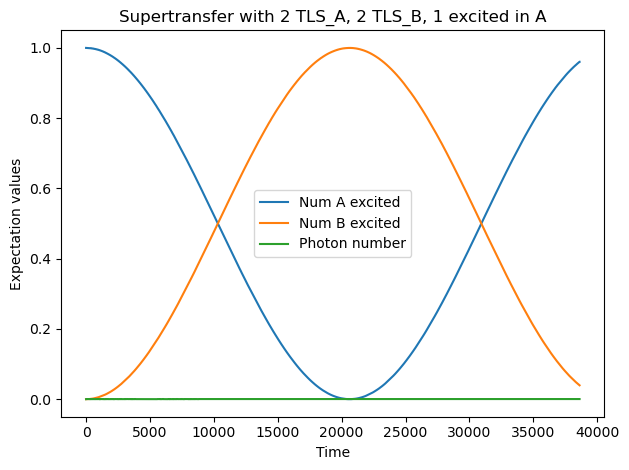

time to transfer one = 5980.7463958623475


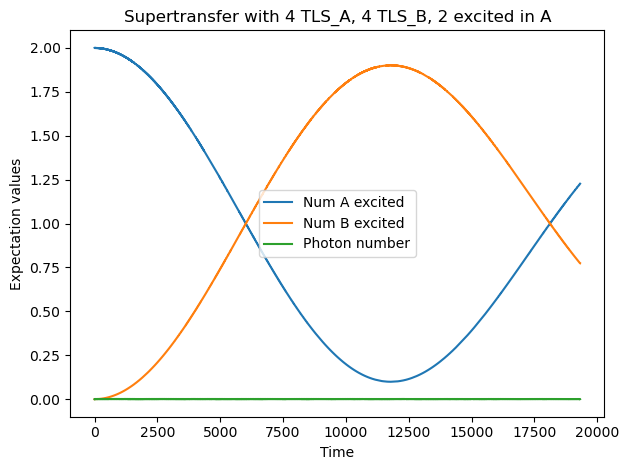

time to transfer one = 2170.629930051451


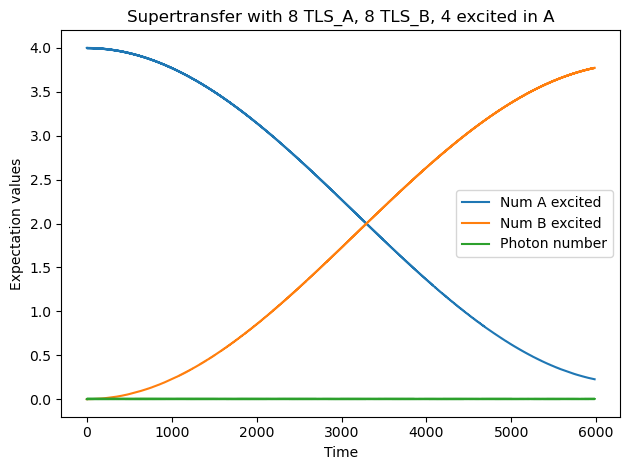

In [16]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,2,4,8]
transfer_times = []
rates = []

tend_ind = -1
tend = 60000


for N in Ns:
    num_excited = N//2 or 1
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list = make_operators_JAB(max_bosons=max_bosons, parity=0, num_TLS_A=N, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(N/2)), N//2)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  tend, 10000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    tend_ind = np.where(np.abs((result.expect[1][0:-1]+ N/2 - 1))<0.01)[0][0]
    time_to_transfer_one = tlist[tend_ind]    
    tend = time_to_transfer_one

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


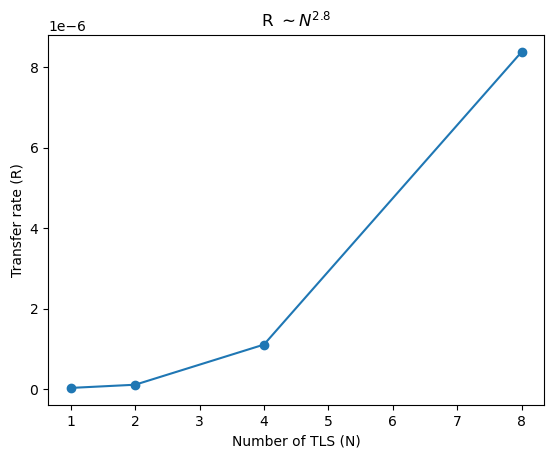

In [17]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");

### N<sub>A</sub> : N<sub>B</sub>,  N TLS excited in A

time to transfer one = 38619.86198619862


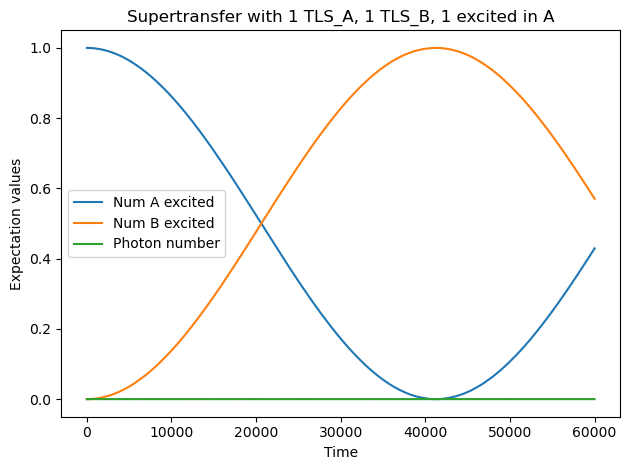

time to transfer one = 15584.672778709015


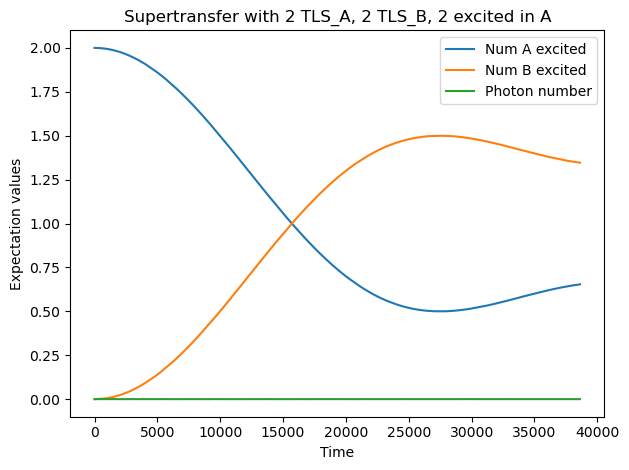

time to transfer one = 7110.438765523605


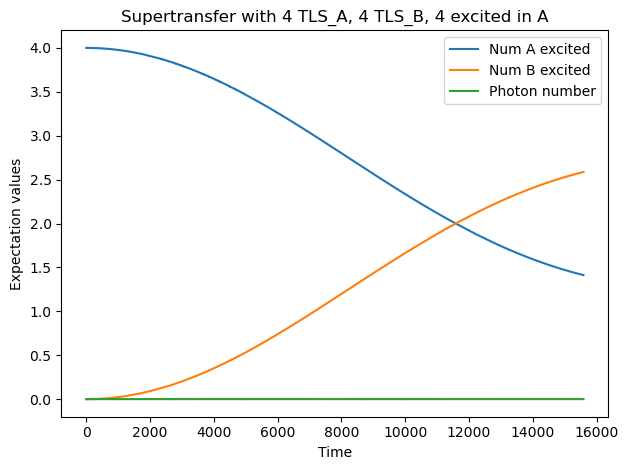

time to transfer one = 3404.1074478009295


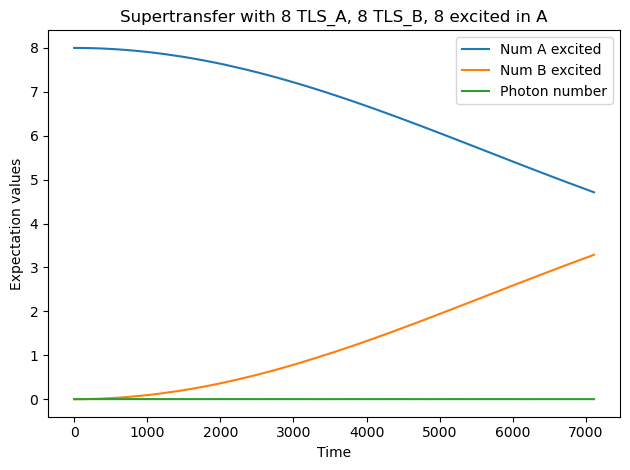

In [14]:
U=0.01
omega=1
deltaE=2.5

Ns = [1,2,4,8]
transfer_times = []
rates = []

tend_ind = -1
tend = 60000


for N in Ns:
    num_excited = N
    max_bosons = num_excited*2
    
    two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nm_list = make_operators_JAB(max_bosons=max_bosons, parity=0, num_TLS_A=N, num_TLS_B=N)

    psi_atom_A = basis(len(m_vals(N/2)), 0)
    psi_atom_B = basis(len(m_vals(N/2)), N)
    psi_field = fock(max_bosons+1, 0)  # Field in vacuum state
    psi0 = tensor(psi_field, psi_atom_A, psi_atom_B)

    
    H = deltaE*two_state_A + deltaE*two_state_B + bosons + U*interaction_A + U*interaction_B
    
    
    # Time list
    tlist = np.linspace(0,  tend, 10000)

    # Evolve the system
    result = mesolve(H, psi0, tlist, [], [two_state_A, two_state_B, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])

    tend_ind = np.where(np.abs((result.expect[1][0:-1]+ N/2 - 1))<0.01)[0][0]
    time_to_transfer_one = tlist[tend_ind]    
    tend = time_to_transfer_one

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    plt.figure()
    
    plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    plt.xlabel("Time")
    plt.ylabel("Expectation values")
    plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    plt.plot(tlist, result.expect[2], label="Photon number")
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()


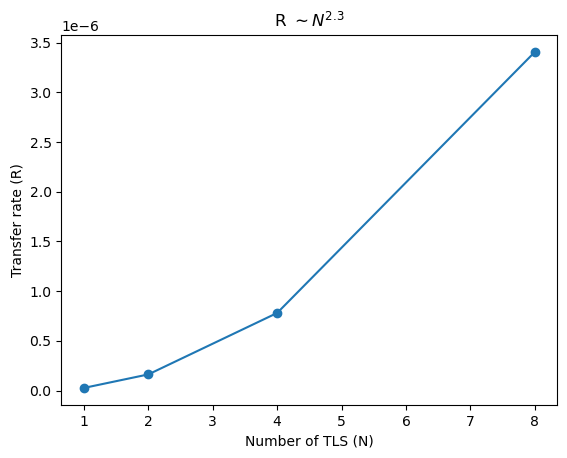

In [15]:
super = pd.DataFrame(data={"N":Ns, "rate":np.multiply(rates,rates), "times":transfer_times})

slope = linregress(np.log10(super["N"]), np.log10(super["rate"])).slope

ax = super.plot(x="N",y="rate", title=f"R $\sim N^{{{round(slope, 1)}}}$", legend=False, style='o-');
ax.set_xlabel("Number of TLS (N)");
ax.set_ylabel("Transfer rate (R)");

### Checking with the $\pm$ basis

In [29]:
from itertools import permutations

def generate_permutations(n_plus, n_minus):
    """Generate permutations of n_plus '+' characters and n_minus '-' characters."""

    if n_plus <=0:
        raise ValueError("n_plus must be positive.")

    if n_minus == 0:
        return ['+'] * n_plus
    
    chars = ['+'] * n_plus + ['-'] * n_minus
    
    # Get all unique permutations of the characters
    seen = set()
    for perm in permutations(chars, n_plus + n_minus):
        if perm not in seen:
            seen.add(perm)
    return list(seen)

time to transfer one = 60000.0


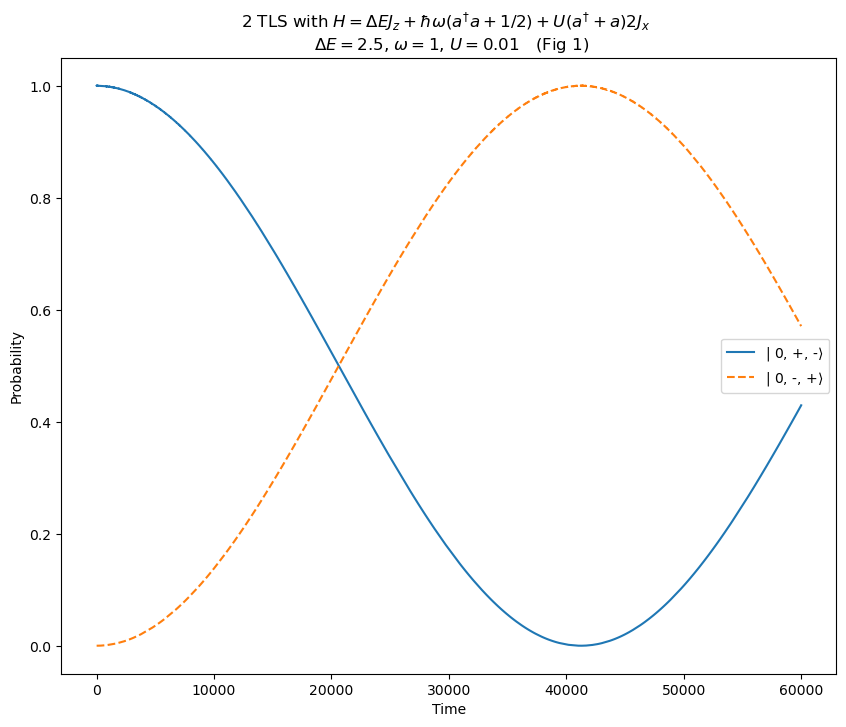

time to transfer one = 60000.0


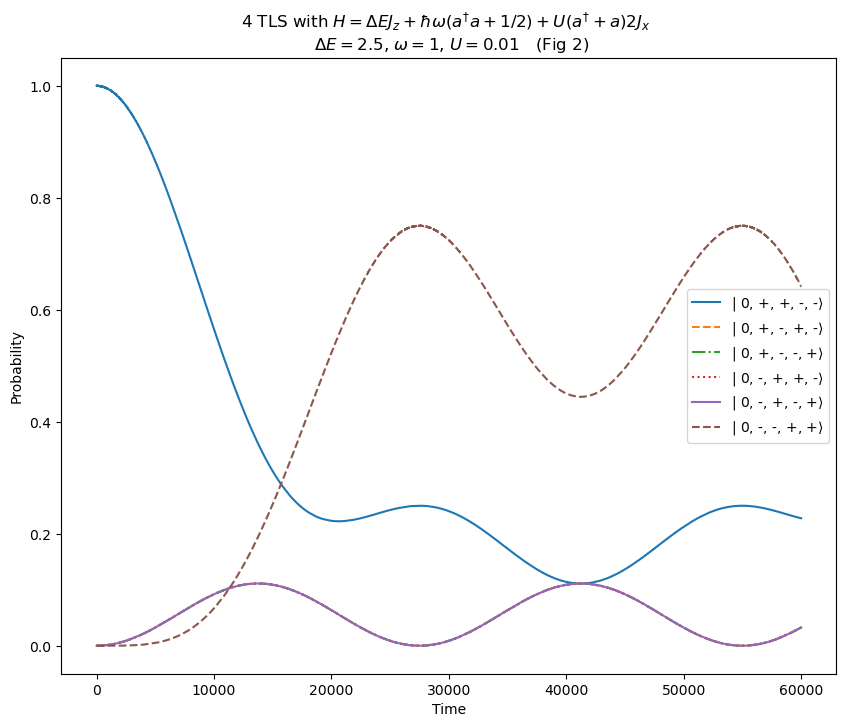

In [123]:
H_latex_AB = "$H = \Delta E J_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_x$ "


U=0.01
omega=1
deltaE=2.5

Ns = [1,2]
transfer_times = []
rates = []

tend_ind = -1
tend = 60000


for N in Ns:
    num_excited = N
    max_bosons = num_excited*2
    
    two_state, bosons, interaction, number, nm_list, J2 = make_operators(max_bosons=max_bosons, parity=0, num_TLS=2*N)

    psi0 = basis([max_bosons+1] + [2 for i in range(2*N)], [0] + [0 for i in range(N)] + [1 for i in range(N)])

    # entangled_state_indices = []
    # TLS_B_psi0 = ("-",)*N
    # psi0 = 0
    # for k in range(0,N):
    #     TLS_A_psi0 = ["-",]*N
    #     TLS_A_psi0[k] = "+"
    #     ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
    #     # print(nm_list[ind])
    #     psi0 += basis(len(nm_list), ind)
    # psi0 = psi0.unit()

    H = deltaE*two_state + bosons + U*interaction
    
    
    # Time list
    tlist = np.linspace(0,  tend, 10000)

    # Evolve the system
    # result = mesolve(H, psi0, tlist, [], [two_state, number])
    # result = mesolve(H, psi0, tlist, [], [psi0*psi0.dag(), number])
    P, psi = simulate(H, psi0, tlist)

    # tend_ind = np.where(np.abs((result.expect[1][0:-1]+ N/2 - 1))<0.01)[0][0]
    time_to_transfer_one = tlist[tend_ind]    
    tend = time_to_transfer_one

    
    
    transfer_times.append(time_to_transfer_one)
    rates.append(2*np.pi / time_to_transfer_one)

    print(f"time to transfer one = {time_to_transfer_one}")

    tend = time_to_transfer_one



    # plt.figure()
    
    # plt.title(f"Supertransfer with {N} TLS_A, {N} TLS_B, {num_excited} excited in A")
    # plt.xlabel("Time")
    # plt.ylabel("Expectation values")
    # plt.plot(tlist, result.expect[0], label="$P (\psi_0)$")
    # # plt.plot(tlist, result.expect[0] + N/2, label="Num A excited")
    # # plt.plot(tlist, result.expect[1] + N/2, label="Num B excited")
    # plt.plot(tlist, result.expect[1], label="Photon number")
    # plt.legend()
    
    
    # plt.tight_layout()
    # plt.show()
    nonzero_P = np.where(np.abs(P.mean(axis=1))>0.01)[0]

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    plot_prob(P[nonzero_P,:] ,tlist, [ket_labels[l] for l in nonzero_P])
    plt.title(f"{2*N} TLS with {H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$   (Fig {N})");
    plt.show()  # Display the plot

In [124]:
generate_permutations(2,2)

[('+', '-', '-', '+'),
 ('-', '+', '-', '+'),
 ('+', '-', '+', '-'),
 ('+', '+', '-', '-'),
 ('-', '+', '+', '-'),
 ('-', '-', '+', '+')]

In [ ]:
A_ind = []
B_ind = []


for TLS_A_psi0 in generate_permutations(N,N):
    ind = nm_list.index((0,) + tuple(TLS_A_psi0) + TLS_B_psi0)
    A_ind.append(ind)


for TLS_A_psi0 in generate_permutations(N,N):
    ind = nm_list.index((0,) + TLS_B_psi0 + tuple(TLS_A_psi0))
    B_ind.append(ind)


plot_prob(np.vstack((P[A_ind,:].sum(axis=0), P[B_ind,:].sum(axis=0))),times,["|0,1,0>","|0,0,1>"])
plt.title(f"{H_latex_AB} \n $\Delta E = {deltaE}$, $\omega={omega}$, $U={U}$ \n  {tls_per_group} TLS in A, {tls_per_group} TLS in B");